# Chapter: Input-Output Modeling - Part 1: 


## Topic: Fitting ARX model to a hypothetical process and estimating bias in parameter estimates

In [1]:
# import packages 
from sippy import functionset as fset
import matplotlib.pyplot as plt
import control
import numpy as np
from sklearn.preprocessing import StandardScaler
from sippy import system_identification as SysID

# package settings
np.random.seed(0)
plt.rcParams.update({'font.size': 14})
assert(control.__version__ < '0.9'), "To avoid errors, downgrade the control package to a version < 0.9.0. See https://github.com/CPCLAB-UNIPI/SIPPY/issues/48 for details."

In [2]:
# define the actual deterministic system
NUM_G = [0.7]
DEN_G = [1, -0.7] 
sys_G = control.matlab.tf(NUM_G, DEN_G, 1)

In [3]:
# define the stochastic system (an AR process)
NUM_H = [1, 0] 
DEN_H = [1, -0.2]
sys_H = control.matlab.tf(NUM_H, DEN_H, 1)

In [4]:
# define input and get deterministic output
Time = np.linspace(0, 999, 1000)
[u, _, _] = fset.GBN_seq(1000, 0.1, Nmin=3)
y_G, _, _ = control.matlab.lsim(sys_G, u, Time)

In [6]:
# generate 500 different sets of stochastic output / disturbance with 1000 samples each with SNR = 10 
# and add the disturbance for each set to deterministic output to obtain 500 sets of I/O data.
# For each set fit an ARX model and get the parameter estimates

y_G_var = np.var(y_G)
white_noise_variance = [y_G_var*0.094]
a_estimates = []
b_estimates = []

for i in range(500):
    # generate disturbance signal
    e = fset.white_noise_var(u.size, white_noise_variance)[0]
    y_H, _, _ = control.matlab.lsim(sys_H, e, Time)
    
    # combined output of simulated system
    y = y_G + y_H
    
    # center data before model fitting
    u_scaler = StandardScaler(with_std=False) 
    u_centered = u_scaler.fit_transform(u[:,None]) 
    
    y_scaler = StandardScaler(with_std=False) 
    y_centered = y_scaler.fit_transform(y[:,None]) 
    
    # fit FIR model
    ARXmodel = SysID(y_centered, u_centered, 'ARX', ARX_orders=[1,1,0])
    
    # get parameter estimates
    a = ARXmodel.DENOMINATOR[0][0][1]
    b = ARXmodel.NUMERATOR[0][0][0]
    a_estimates.append(a)
    b_estimates.append(b)

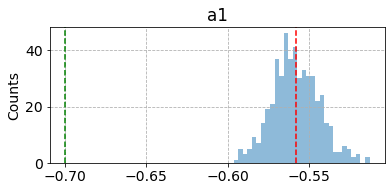

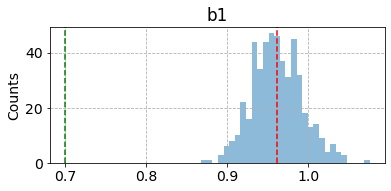

In [8]:
# generate histogram of parameter estimates
a_mean = np.mean(a_estimates)
b_mean = np.mean(b_estimates)

plt.figure(figsize=(6,2.5))
plt.hist(a_estimates, bins=30, histtype='barstacked', alpha=0.5)
plt.axvline(x=a_mean, color='r', ls='--')
plt.axvline(x=-0.7, color='g', ls='--')
plt.grid(which='both', linestyle='--')
plt.ylabel('Counts'), plt.title('a1')

plt.figure(figsize=(6,2.5))
plt.hist(b_estimates, bins=30, histtype='barstacked', alpha=0.5)
plt.axvline(x=b_mean, color='r', ls='--')
plt.axvline(x=0.7, color='g', ls='--')
plt.grid(which='both', linestyle='--')
plt.ylabel('Counts'), plt.title('b1')
plt.show()